In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pickle 
from tqdm import tqdm

import automata as dfa
import utils

## Global Variables

In [2]:
ATT_PATH = "./data/languages/att/"
DATA_PATH = "./data/Small/"
NAMES_PATH = "./names.txt"

BATCH_SIZE = 200

N_EPOCH = 150
EPOCH_VERBOSE = 50
LEARNING_RATES = 0.5

torch.manual_seed(689)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

## Load the datas

In [3]:
names, extensions = utils.lang_names(NAMES_PATH)
print(names, extensions, sep="\n")

datas = dict()
automata = dict()
for name in names:
    datas[name], automata[name] = utils.data_automata_loading(ATT_PATH, DATA_PATH, name, extensions, return_automata=True)

['04.03.TLTT.2.3.0', '04.03.TLTT.4.2.3', '04.04.Reg.0.0.9', '04.04.Zp.2.1.0', '16.04.TLT.2.1.4', '16.16.LT.4.1.5', '16.16.SP.2.1.0', '64.64.SF.0.0.0', '64.64.SL.4.1.0']
['_Dev', '_TestLA', '_TestLR', '_TestSA', '_TestSR', '_Train']


In [4]:
def makeloader(name:str, datas)-> tuple[DataLoader, list[torch.Tensor]]:
    train = DataLoader(datas[name]["_Train"], BATCH_SIZE, shuffle=True)
    test = next(iter(DataLoader(datas[name]["_Dev"], len(datas[name]["_Dev"]))))

    return train, test

## Model

In [5]:
class LossInvParam(nn.Module):
    "Custom loss with inverse parameters as dampling arguments."

    def __init__(self, alpha = 0.1, loss = nn.BCELoss()) -> None:
        super().__init__()
        self.loss = loss
        self.alpha = alpha
        self.model = None

    def set_model(self, model:nn.Module):
        self.model = model
    
    def forward(self, predictions, labels):
        if self.model is None:
            raise ValueError("'model' haven't been set up in the loss.")
        invsum = 0
        for parameters in self.model.parameters():
            invsum += torch.linalg.matrix_norm(parameters)**2
        invsum = 1/torch.sqrt(invsum)
        return self.loss(predictions, labels) + invsum * self.alpha

In [6]:
def single_model_training(model:nn.Module, optim:torch.optim.Optimizer, loss:nn.Module, target:list[torch.Tensor], trainloader:DataLoader, test:list[torch.Tensor]):

    statsdict = utils.initstats(utils.STATS_NAMES)

    for batchepoch in range(N_EPOCH//EPOCH_VERBOSE):
        for _ in tqdm(range(EPOCH_VERBOSE), desc=f"Epoch {batchepoch*EPOCH_VERBOSE + 1} to {(batchepoch+1)*EPOCH_VERBOSE}...", ncols=75):
            for words, lengths, labels in trainloader:
                labels = labels.to(dtype = torch.float32)

                out = model(words, lengths)

                newloss = loss(out, labels)
                newloss.backward()
                statsdict["losses"].append(newloss.item())

                stats = utils.stats(model, target, LEARNING_RATES)
                statsdict["l2"].append(stats[0])
                statsdict["linf"].append(stats[1])
                statsdict["linedist"].append(stats[2])
                statsdict["targetdist"].append(stats[3])
                

                optim.step()
                optim.zero_grad()

            with torch.no_grad():
                predictions = model.predict(test[0], test[1])
                statsdict["acc"].append(torch.sum(predictions == test[2].reshape(-1), dim=0).item() * 100 / len(test[2]))
        print(f"Done! Trainloss: {statsdict['losses'][-1]:.6f}, Test accuracy: {statsdict['acc'][-1]:.4f}")

    return statsdict



def train_and_stats(name:str, datas:dict[dict[dfa.TorchData]], automaton:dfa.DFA, loss = nn.BCELoss(), optimizer = torch.optim.Adam, returnmodel=False):
    
    
    trainloader, test = makeloader(name, datas)
    target = dfa.sigmoid_to_tanh(dfa.dfa2srn(automaton.transition.T, automaton.finites))

    noparam = dfa.AutomataRNN(automaton, device=DEVICE).to(DEVICE)
    noparam.high_init()
    optim = optimizer(noparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    if isinstance(loss, LossInvParam):
        loss.set_model(noparam)

    statsnoparam = single_model_training(noparam, optim, loss, target, trainloader, test)

    print("\nNon parametrized RNN done!\n")

    withparam = dfa.ParametrizeRNN(automaton, device=DEVICE).to(DEVICE)
    withparam.high_init()
    optim = optimizer(withparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    if isinstance(loss, LossInvParam):
        loss.set_model(withparam)

    statsparam = single_model_training(withparam, optim, loss, target, trainloader, test)
    print("\nParametrized RNN done!")

    if returnmodel:
        return (statsnoparam, noparam), (statsparam, withparam)
    else:
        return statsnoparam, statsparam
            

In [7]:
def save_stats(path:str, all_stats, **parameters):
    with open(path, "wb") as file:
        pickle.dump([parameters, all_stats], file)

## Training

In [8]:
(statsnoparam, noparam), (statsparam, withparam) = train_and_stats(names[1], datas, automata[names[1]], loss= nn.BCELoss(), returnmodel=True)


Non parametrized RNN done!


Parametrized RNN done!


In [9]:
all_stats = dict()
for name in names:
    print(f"{name} training...")
    all_stats[name] = train_and_stats(name, datas, automata[name], optimizer=torch.optim.SGD, loss = dfa.Binary_nthRoot_Loss())#, loss = LossInvParam(alpha=1))
    save_stats("saved_mlreg_stats2.pkl", all_stats, lr = LEARNING_RATES, epoch = N_EPOCH, optim = "Adam", loss = "nthLoss", nth=2, batch_size = BATCH_SIZE)


04.03.TLTT.2.3.0 training...

Non parametrized RNN done!


Parametrized RNN done!
04.03.TLTT.4.2.3 training...

Non parametrized RNN done!


Parametrized RNN done!
04.04.Reg.0.0.9 training...

Non parametrized RNN done!


Parametrized RNN done!
04.04.Zp.2.1.0 training...

Non parametrized RNN done!


Parametrized RNN done!
16.04.TLT.2.1.4 training...

Non parametrized RNN done!


Parametrized RNN done!
16.16.LT.4.1.5 training...

Non parametrized RNN done!


Parametrized RNN done!
16.16.SP.2.1.0 training...

Non parametrized RNN done!


Parametrized RNN done!
64.64.SF.0.0.0 training...

Non parametrized RNN done!


Parametrized RNN done!
64.64.SL.4.1.0 training...

Non parametrized RNN done!


Parametrized RNN done!


In [10]:
with open("saved_mlreg_stats1.pkl", 'rb') as file:
    parameters, all_stats = pickle.load(file)

In [11]:
parameters #16.16.SP.2.1.0

{'lr': 0.01, 'epoch': 150, 'optim': 'Adam', 'loss': 'BCE', 'batch_size': 200}

In [12]:
parameters #04.03.TLTT.4.2.3

{'lr': 0.01, 'epoch': 150, 'optim': 'Adam', 'loss': 'BCE', 'batch_size': 200}

In [13]:
parameters #04.04.Zp.2.1.0

{'lr': 0.01, 'epoch': 150, 'optim': 'Adam', 'loss': 'BCE', 'batch_size': 200}

## Plots

04.03.TLTT.2.3.0


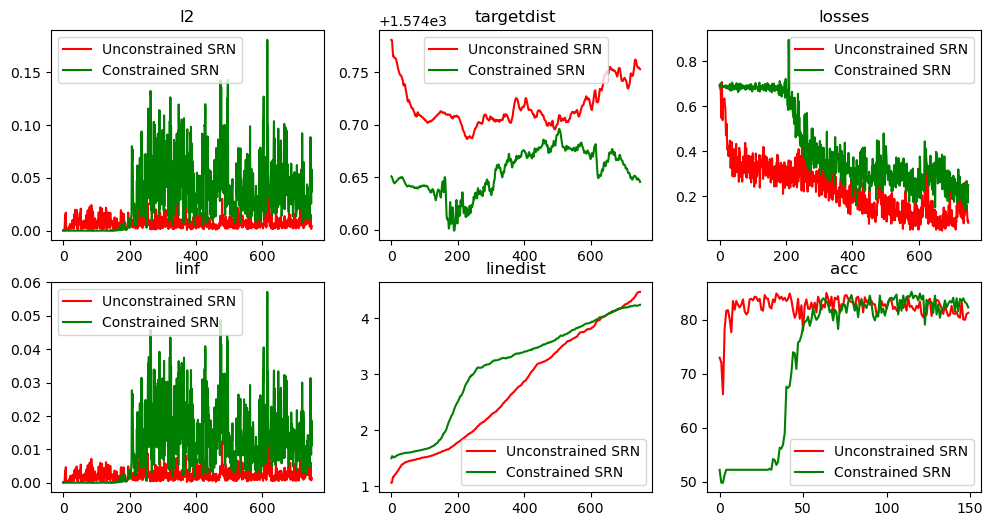

In [14]:
statsnoparam, statsparam = all_stats[names[0]]
#utils.plot_stats(statsnoparam)
#utils.plot_stats(statsparam)
print(names[0])
utils.plot_stats(statsnoparam, statsparam)

04.03.TLTT.2.3.0


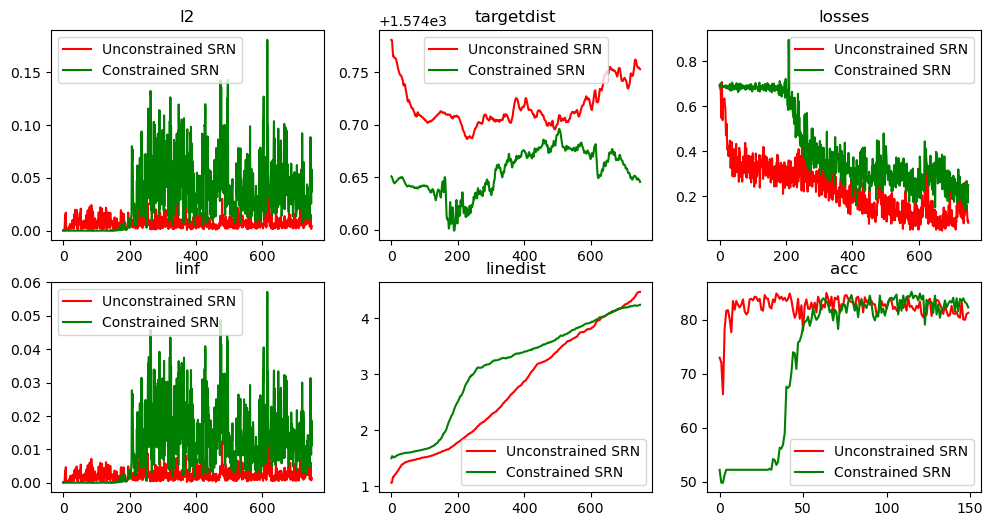

04.03.TLTT.4.2.3


KeyboardInterrupt: 

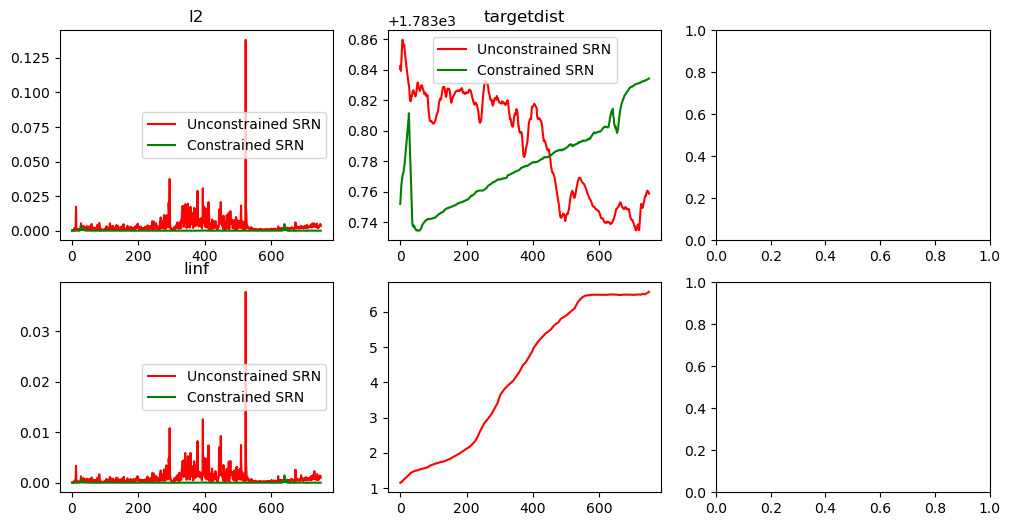

In [15]:
for name in names:
    try:
        statsnoparam, statsparam = all_stats[name]
    #utils.plot_stats(statsnoparam)
    #utils.plot_stats(statsparam)
        print(name)
        utils.plot_stats(statsnoparam, statsparam)
    except KeyError:
        print(name, "not found...")